<a href="https://colab.research.google.com/github/Spoorthy-gunda/Stock_Prediction/blob/main/aircanada_stock_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.initializers import RandomNormal  
from keras import optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import csv
import pandas as pd



data=pd.read_csv("/content/AC.TO_from2010.csv")
data.describe()



,Open,High,Low,Close,Adj Close,Volume
count,2758.000000,2758.000000,2758.000000,2758.000000,2758.000000,2.758000e+03
mean,14.003894,14.236806,13.762893,13.999126,13.999126,2.040237e+06
std,12.384356,12.570921,12.217991,12.396405,12.396405,2.181328e+06
min,0.800000,0.830000,0.780000,0.820000,0.820000,0.000000e+00
25%,2.782500,2.832500,2.730000,2.800000,2.800000,8.309250e+05
50%,10.905000,11.095000,10.650000,10.890000,10.890000,1.320350e+06
75%,22.920000,23.240000,22.497500,22.905000,22.905000,2.418275e+06
max,52.029999,52.709999,51.560001,52.090000,52.090000,2.715840e+07


In [2]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-04-28,2.42,2.43,2.35,2.35,2.35,347400.0
1,2010-04-29,2.34,2.35,2.25,2.25,2.25,1156100.0
2,2010-04-30,2.25,2.31,2.22,2.23,2.23,743000.0
3,2010-05-03,2.21,2.28,2.21,2.25,2.25,621700.0
4,2010-05-04,2.24,2.24,2.09,2.17,2.17,1030500.0


In [3]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2755,2021-04-21,23.180000,23.850000,22.700001,23.639999,23.639999,3685400.0
2756,2021-04-22,23.760000,24.850000,23.650000,24.690001,24.690001,4601400.0
2757,2021-04-23,24.770000,25.190001,24.600000,25.070000,25.070000,2922300.0
2758,2021-04-26,25.320000,25.879999,25.190001,25.760000,25.760000,2969200.0
2759,2021-04-27,25.870001,25.870001,25.430000,25.740000,25.740000,2501400.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2760 non-null   object 
 1   Open       2758 non-null   float64
 2   High       2758 non-null   float64
 3   Low        2758 non-null   float64
 4   Close      2758 non-null   float64
 5   Adj Close  2758 non-null   float64
 6   Volume     2758 non-null   float64
dtypes: float64(6), object(1)
memory usage: 151.1+ KB


In [5]:
data.isnull().sum()

Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64

Since the number of null entries is same for every column, it is possible that the the null entries belong to the same rows. We can check this by the following code.

In [6]:
data=data.dropna(how='any')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2758 entries, 0 to 2759
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2758 non-null   object 
 1   Open       2758 non-null   float64
 2   High       2758 non-null   float64
 3   Low        2758 non-null   float64
 4   Close      2758 non-null   float64
 5   Adj Close  2758 non-null   float64
 6   Volume     2758 non-null   float64
dtypes: float64(6), object(1)
memory usage: 172.4+ KB


The above code deletes the rows which has at least on null entry. After deleting such rowns we can observe that null values are present only on two rowshence we can safely delete those two rows.

In [7]:
data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999718,0.999585,0.999440,0.999440,0.047862
High,0.999718,1.000000,0.999470,0.999740,0.999740,0.054342
Low,0.999585,0.999470,1.000000,0.999711,0.999711,0.037188
Close,0.999440,0.999740,0.999711,1.000000,1.000000,0.046175
Adj Close,0.999440,0.999740,0.999711,1.000000,1.000000,0.046175
Volume,0.047862,0.054342,0.037188,0.046175,0.046175,1.000000


In [8]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

We will consider the high prices everyday and predict the prices in the future. Let us train a model that looks into the high prices of one stock for the past 60 days and predicts the next day high price. For this let us first create the dataset and split into train and test sets.

In [9]:
data_n=data['High']
data_n[0]

2.43

We will now create the training data with high prices of 60 days per data point with target being the high price on 61st day.

In [10]:
X=[]
Y=[]
for i in range (0,len(data_n)-60):
  X.append(data_n[i:i+60])
  Y.append(data_n[i+60])
X=np.array(X)
Y=np.array(Y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape

(2698, 60, 1)

Let us now split the dataset to train and test sets. We split the first 2100 datapoints as the train and the remaining as test

In [11]:
# from sklearn.model_selection import train_test_split
X_train= X[0:2100,:,:]
Y_train= Y[0:2100]
X_test=X[2100:,:,:]
Y_test=Y[2100:]
# X_test= np.concatenate((X[0:350,:,:],X[2250:2698,:,:]))
# Y_test= np.concatenate((Y[0:250],Y[2250:2698]))
print(X_test.shape,Y_test.shape)


(598, 60, 1) (598,)


Epoch 100/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0098 - val_loss: 89.4783


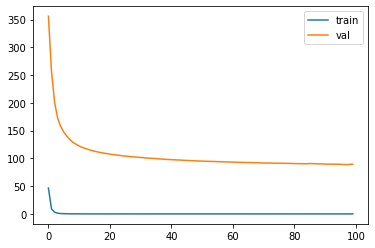

In [12]:
model=Sequential()
model.add(LSTM(120, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True))
model.add(LSTM(120, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=False)) 
# model.add(LSTM(120, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=False))  
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')


history=model.fit(X_train, Y_train,batch_size=50,epochs=100, validation_data=(X_test, Y_test), shuffle=True)

model.save('mnist_lenet.h5')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()





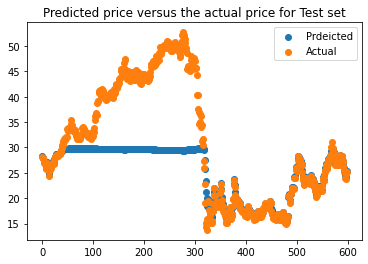

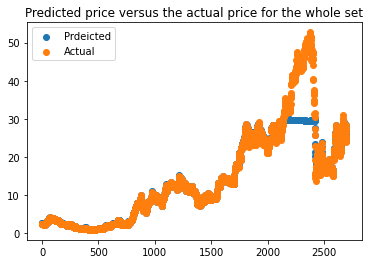

In [13]:
labels=[i for i in range(len(Y_test))]
predicted_prices=model.predict(X_test)
plt.scatter(labels,predicted_prices)
plt.scatter(labels,Y_test)
plt.legend(["Prdeicted", "Actual"])
plt.title("Predicted price versus the actual price for Test set")
plt.show()

labels=[i for i in range(len(Y))]
predicted_prices=model.predict(X)
plt.scatter(labels,predicted_prices)
plt.scatter(labels,Y)
plt.legend(["Prdeicted", "Actual"])
plt.title("Predicted price versus the actual price for the whole set")
plt.show()